In [ ]:
from google.colab import drive
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, Activation
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import numpy as np
import os 
from os import listdir
from random import sample
import pandas as pd
import random
np.random.seed(2)
np.random.RandomState(2)
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D
import cv2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import ConfusionMatrixDisplay
from keras.models import load_model
import sklearn
from collections import Counter
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications import ResNet50
tf.random.set_seed(2)

# A Note on File Paths

The below code was written in Google Colab due to the time required to model the data. This notebook was mounted on the Google Drive, on the code file paths reflect as such. 

Similarly named files, i.e. the original images saved down in a file called 'raw_dataset' should result in the code running without issues.

If any guidance is required, users are encouraged to reach out via Github.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Read in the image dataset.

In [ ]:
data_path = '/content/drive/MyDrive/clothing_class/raw_dataset'
imseg_data_path_kmeans = '/content/drive/MyDrive/clothing_class/segmented_images/cv2images_kmeans'
imseg_data_path_kmeans3 = '/content/drive/MyDrive/clothing_class/segmented_images/cv2images_kmeans3'
imseg_data_path_contour = '/content/drive/MyDrive/clothing_class/segmented_images/cv2images_contour'
imseg_data_path_thresh = '/content/drive/MyDrive/clothing_class/segmented_images/cv2images_thresholding'

## Read in CSV Files

In [ ]:
clothes_df = pd.read_csv('/content/drive/MyDrive/clothing_class/dataset.csv')
resampled_df = pd.read_csv('/content/drive/MyDrive/clothing_class/data_resampled.csv')

## Image Data Generator

The training image tensor data will be generated with the only augmentation being a rescaling, horizontal flip and rotation range of up to 40 degrees.

The test set is rescaled.

The dataset is split 80% to training, 20% to validation.

In [ ]:
train_gen = ImageDataGenerator(
    rescale = 1/255,
    horizontal_flip = True,
    rotation_range = 40,
    validation_split=0.2,
)

test_gen = ImageDataGenerator(
    rescale = 1/255,
    validation_split=0.2,
)

## Generate Image Tensor Data

The function below generates the tensor data that will be used for modeling.

The function can be used for both training and testing sets, both garment and pattern modeling via the y-col argument, and reads in a specified dataset so that any of the segmented datasets can be selected.

In [ ]:
def tensor_data(image_gen,data_frame,image_data_path,y_column,subset):
  tensor_data = image_gen.flow_from_dataframe(
  dataframe=data_frame,
  directory=image_data_path,
  x_col="file_name",
  y_col=y_column,
  batch_size=32,
  shuffle=False,
  color_mode='rgb',
  class_mode="categorical",
  subset=subset,
  random_state=2,
  seed=2,
  target_size=(224,224),
  validate_filenames=False)

  return tensor_data

## Early Stop

Setting up an early stop regularization that will monitor increases in val loss metric.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=15,
                           verbose=0,
                          )

## Checkpoint

This checkpoint feature will save down the best performing epoch, based on validation accuracy, that will provide a model on which predictions and evaluations can be performed.

In [ ]:
def checkpoint(cp_name):
  return ModelCheckpoint(
                             monitor='val_accuracy', 
                             verbose=0, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto',
                             filepath ='/content/drive/MyDrive/clothing_class/models/'+str(cp_name)
                             )

## Model Functions

Setting up a model function so that several other transfer learning models can be modeled on the data.

In [ ]:
def model_function(tl_model,classes,alr):
  
    base_model = tl_model(include_top=False,
                     input_shape=(224, 224, 3),
                     weights='imagenet'
                     )
    for layer in base_model.layers:
        layer.trainable = False
    
    model = tf.keras.Sequential([
        
        base_model,
        
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(32,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.2),

        tf.keras.layers.Dense(64,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.2),
        
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.2),

        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.2),

        tf.keras.layers.Dense(64,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.2),
        
        tf.keras.layers.Dense(32,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64,activation='relu'),
        tf.keras.layers.Dense(64,activation='relu'),

        tf.keras.layers.Dense(units=classes, activation='softmax')
    ])
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=alr),
        metrics=['accuracy']
    )
    
    return model

## Plot Functions

A function was built to plot the accuracy and validation accuracy at each epoch. The plot is displayed and saved down to a seperate folder.

In [ ]:
def plot_accuracy(history,title,ext):
  plt.figure(figsize=(20,10))
  plt.plot(history.history['accuracy'], label='Train')
  plt.plot(history.history['val_accuracy'], label='Test')
  plt.ylabel('Accuracy',fontsize=20)
  plt.xlabel('Epochs',fontsize=20)
  plt.legend(prop={'size': 20})
  plt.title(title,fontsize=20)
  plt.savefig('/content/drive/MyDrive/clothing_class/jpeg_folder/'+str(ext)+'_acc.jpeg',format='jpeg',bbox_inches='tight');

A function was built to plot the confusion matrix for each model, using the model predictions and the ground truths for the test set. The matrix is displayed and saved down to a seperate folder.

In [ ]:
def plot_confusion_matrix(checkpoint,test_data,title,ext):
  preds = load_model('/content/drive/MyDrive/clothing_class/models/'+checkpoint).predict(test_data)
  top_pred = np.argmax(preds,axis=1)

  labels = (test_data.class_indices)
  labels = dict((v,k) for k,v in labels.items())
  predictions = [labels[k] for k in top_pred]

  label_true = [labels[k] for k in test_data.classes]

  fig,ax = plt.subplots(figsize=(20,10))
  ConfusionMatrixDisplay.from_predictions(label_true,
                                        predictions,cmap='Blues',
                                        ax=ax,
                                        )
  ax.set_xlabel('Predicted Label',fontsize=15)
  ax.set_ylabel('True Label',fontsize=15)
  plt.title(title,fontsize=20)
  plt.show()
  fig.savefig('/content/drive/MyDrive/clothing_class/jpeg_folder/'+str(ext)+'_cm.jpeg',format='jpeg',bbox_inches='tight');

## Function for Calculating Balanced Accuracy

A function was created to calculate the balanced accuracy for a given model and dataset.

In [ ]:
def calculate_balanced_acc(model,dataframe,image_file,y_col):
  
  test_data = tensor_data(test_gen,dataframe,image_file,
                   y_col,'validation')
  
  preds = load_model('/content/drive/MyDrive/clothing_class/models/'+model).predict(test_data)
  top_pred = np.argmax(preds,axis=1)

  labels = (test_data.class_indices)
  labels = dict((v,k) for k,v in labels.items())
  predictions = [labels[k] for k in top_pred]

  label_true = [labels[k] for k in test_data.classes]

  return sklearn.metrics.balanced_accuracy_score(label_true,predictions)

## Baselines

Reviewing the baseline values for these datasets to determine the accuracy level that must be surpassed to determine that a model performs better than merely choosing the majority class every time.

In [ ]:
clothes_df['garment_label'].value_counts(normalize=True)

dress      0.139226
sweater    0.136002
coat       0.134484
pants      0.129932
tshirt     0.116654
top        0.107360
jacket     0.087253
shorts     0.086495
skirt      0.062595
Name: garment_label, dtype: float64

The garment baseline for the dataset is ~14%.

In [ ]:
clothes_df['pattern_label'].value_counts(normalize=True)

solid        0.567527
horiz        0.161798
polka        0.091426
vertical     0.040971
chevron      0.039264
checkered    0.039264
animal       0.036039
paisley      0.023710
Name: pattern_label, dtype: float64

The pattern baseline for the whole dataset is 56.7%.

In [ ]:
resampled_df['pattern_label'].value_counts(normalize=True)

horiz        0.296386
solid        0.207783
polka        0.167477
vertical     0.075052
chevron      0.071925
checkered    0.071925
animal       0.066018
paisley      0.043433
Name: pattern_label, dtype: float64

The pattern baseline for the resampled dataset (which downsamples solid patterns) is ~30%. The resampled dataset will only be used for pattern modeling.

# Modeling

The purpose of the additional modeling below is to run models on another transfer learning architectures - ResNet50 - that is commonly used in the computer vision space, to see if model performace improves.

## Transfer Learning Pattern Model - ResNet50

94781440/94765736 [==============================] - 1s 0us/step
Found 2303 non-validated image filenames belonging to 8 classes.
Found 575 non-validated image filenames belonging to 8 classes.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_rp/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_rp/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_rp/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_rp/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_rp/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_rp/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_rp/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_rp/assets
INFO:tensorflow:Assets written to: /co

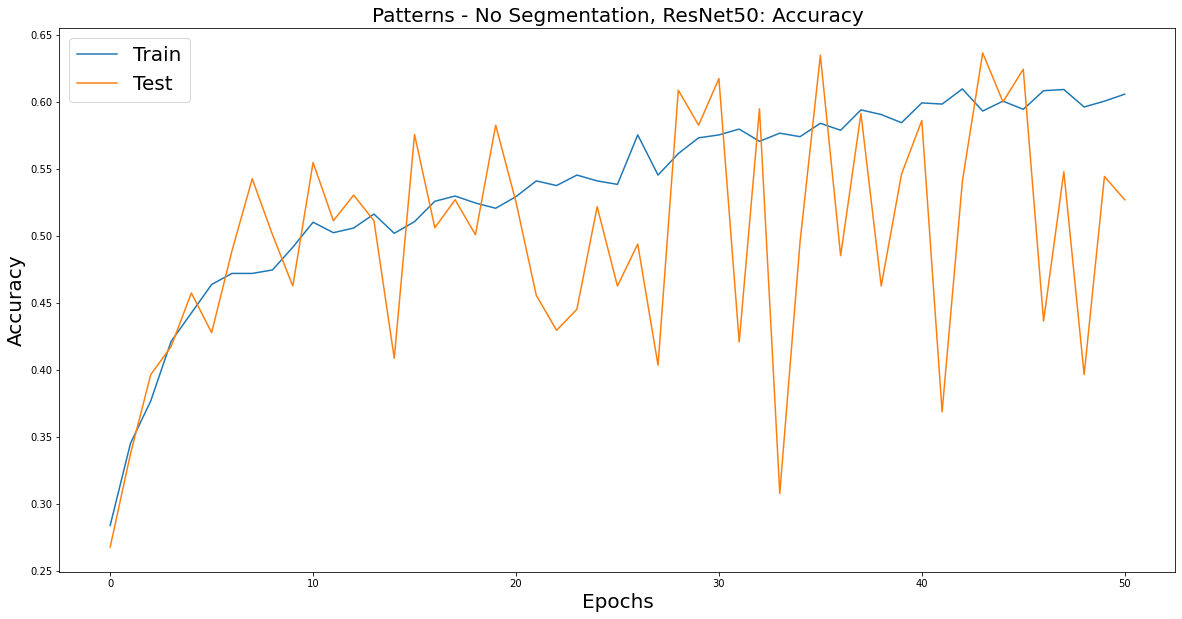

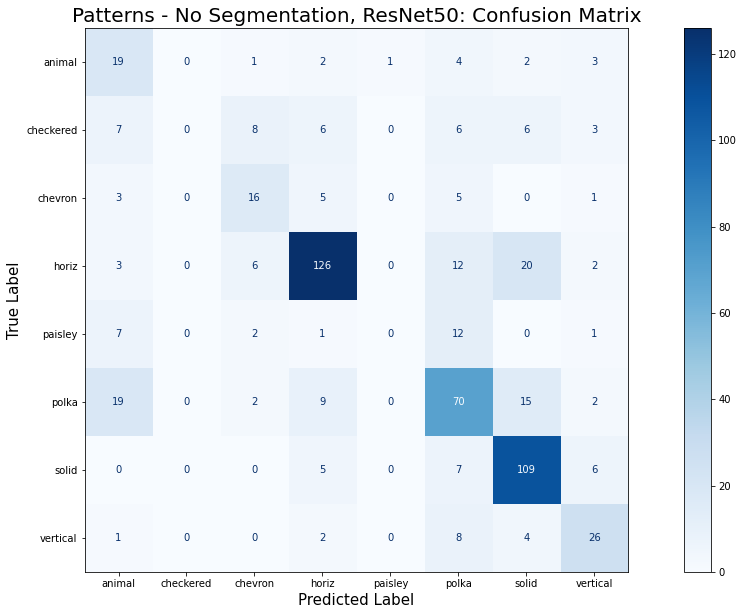

In [ ]:
model_rp = model_function(tl_model=ResNet50,classes = 8,alr=.01)

train_data = tensor_data(train_gen,resampled_df,data_path,
                  'pattern_label','training')

test_data = tensor_data(test_gen,resampled_df,data_path,
                  'pattern_label','validation')

checkpoint_model_rp = checkpoint('model_rp')

history_model_rp = model_rp.fit(
    train_data,
    batch_size = 32,
    epochs=200,
    verbose=0,
    validation_data = test_data,
    callbacks = [checkpoint_model_rp,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_model_rp,'Patterns - No Segmentation, ResNet50: Accuracy',
              'res_pattern_transfer')

plot_confusion_matrix('model_rp',test_data,
                      'Patterns - No Segmentation, ResNet50: Confusion Matrix',
                      'res_pattern_transfer')

In [ ]:
max(history_model_rp.history['val_accuracy'])

0.6365217566490173

In [ ]:
calculate_balanced_acc('model_rp',resampled_df,data_path,'pattern_label')

Found 575 non-validated image filenames belonging to 8 classes.


0.4954187649750368

The ResNet50 model achieves a validation accuracy of 63.65%, and a balanced accuracy score of just 49.54%. This is much lower than the balanced accuracy achieved by the VGG16 model.

Within the test set, the model never predicts checkered and predicts paisley once.

## Transfer Learning Garment Model - ResNet50

Found 4218 non-validated image filenames belonging to 9 classes.
Found 1054 non-validated image filenames belonging to 9 classes.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_rg2/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_rg2/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_rg2/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_rg2/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_rg2/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_rg2/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_rg2/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_rg2/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_rg2/asse

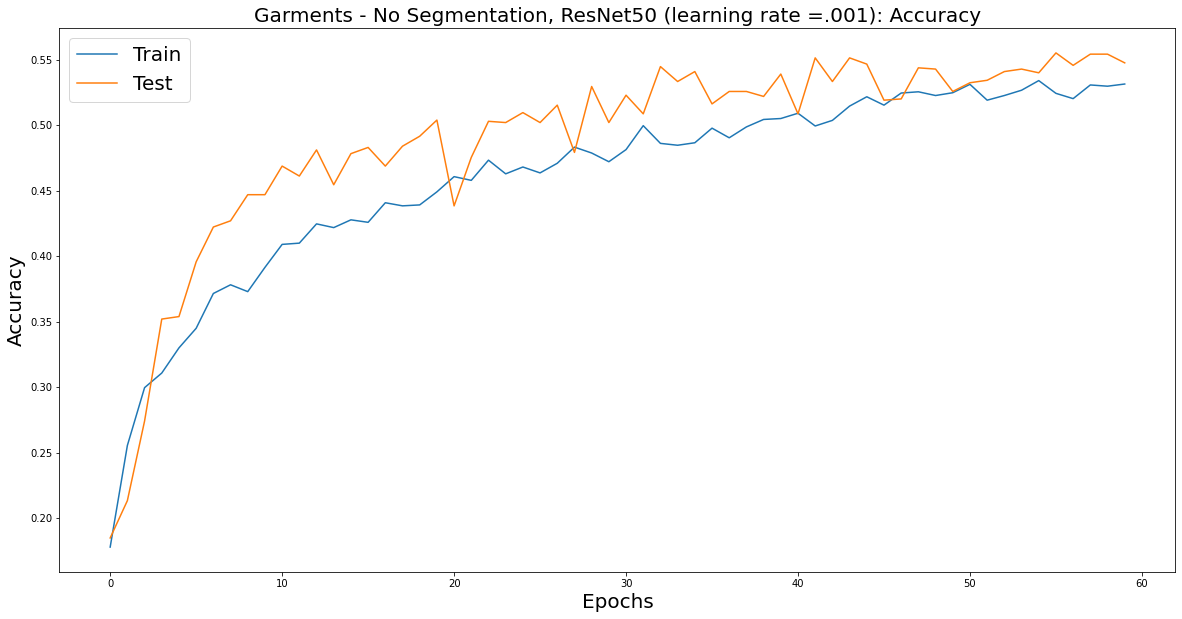

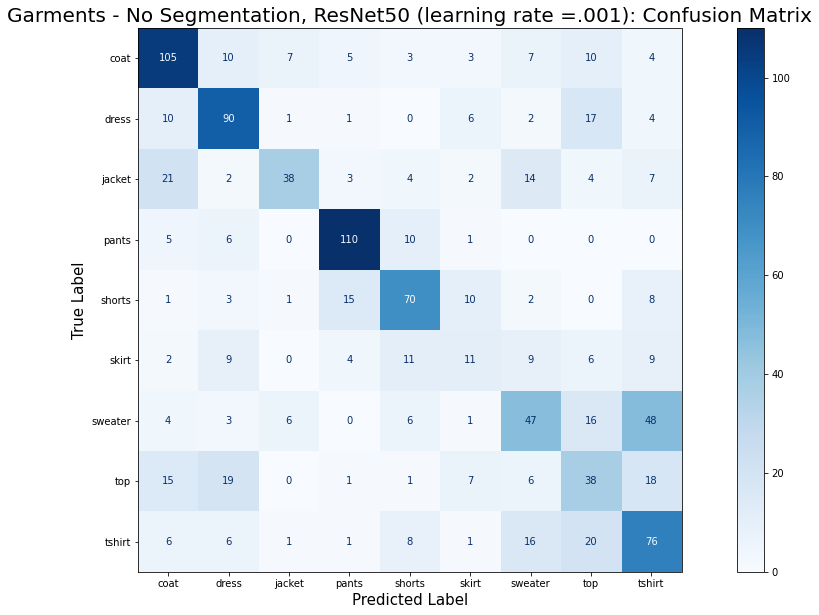

In [ ]:
model_rg2 = model_function(tl_model=ResNet50,classes = 9,alr=.001)

train_data = tensor_data(train_gen,clothes_df,data_path,
                  'garment_label','training')

test_data = tensor_data(test_gen,clothes_df,data_path,
                  'garment_label','validation')

checkpoint_model_rg2 = checkpoint('model_rg2')

history_model_rg2 = model_rg2.fit(
    train_data,
    batch_size = 32,
    epochs=200,
    verbose=0,
    validation_data = test_data,
    callbacks = [checkpoint_model_rg2,early_stop],
    validation_batch_size=32
)

plot_accuracy(history_model_rg2,'Garments - No Segmentation, ResNet50 (learning rate =.001): Accuracy',
              'resnet_garment_transfer2')

plot_confusion_matrix('model_rg2',test_data,
                      'Garments - No Segmentation, ResNet50 (learning rate =.001): Confusion Matrix',
                      'resnet_garment_transfer2')

In [ ]:
max(history_model_rg2.history['val_accuracy'])

0.5550284385681152

In [ ]:
calculate_balanced_acc('model_rg2',clothes_df,data_path,'garment_label')

Found 1054 non-validated image filenames belonging to 9 classes.


0.5225013635503214

The ResNet50 model achieves a validation accuracy of 55.5%, and balanced accuracy of 52.25%, which is again considerably lower than the balanced accuracy score achieved by the VGG16 model.

# Tweaking Best Performing VGG16 Model

Making changes to learning rate, batch size to see if there is any improvement in performance.

## VGG16 Model - No Segmentation, Less Augmentation, LR =.001 - Pattern

58900480/58889256 [==============================] - 0s 0us/step
Found 2303 non-validated image filenames belonging to 8 classes.
Found 575 non-validated image filenames belonging to 8 classes.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_nsa_001/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_nsa_001/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_nsa_001/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_nsa_001/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_nsa_001/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_nsa_001/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vp_nsa_001/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/model

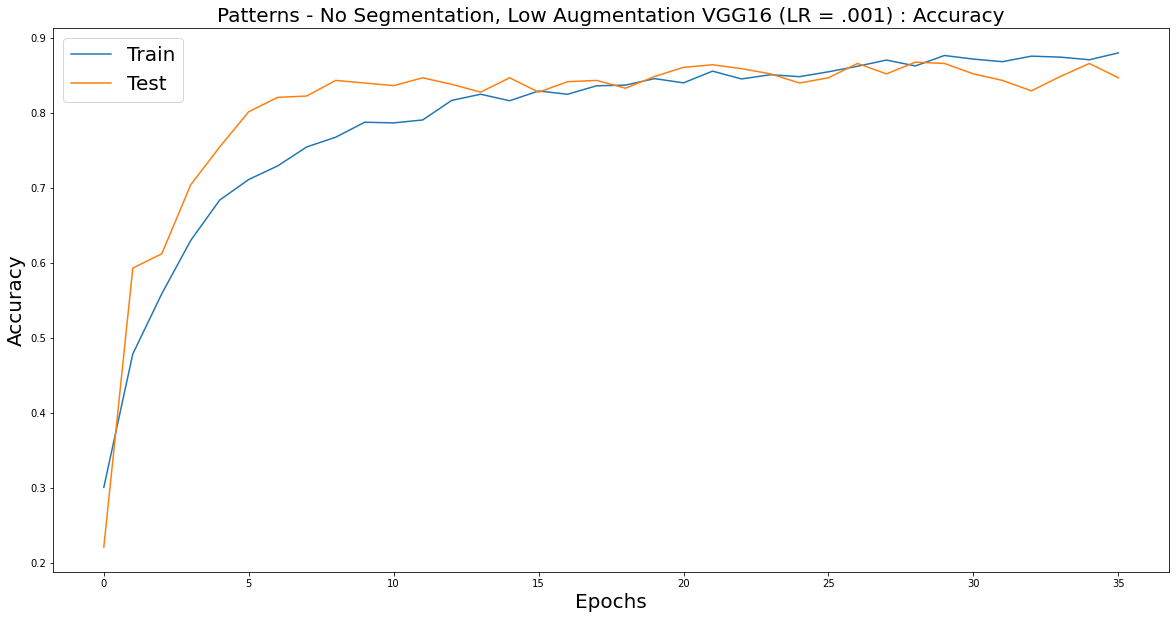

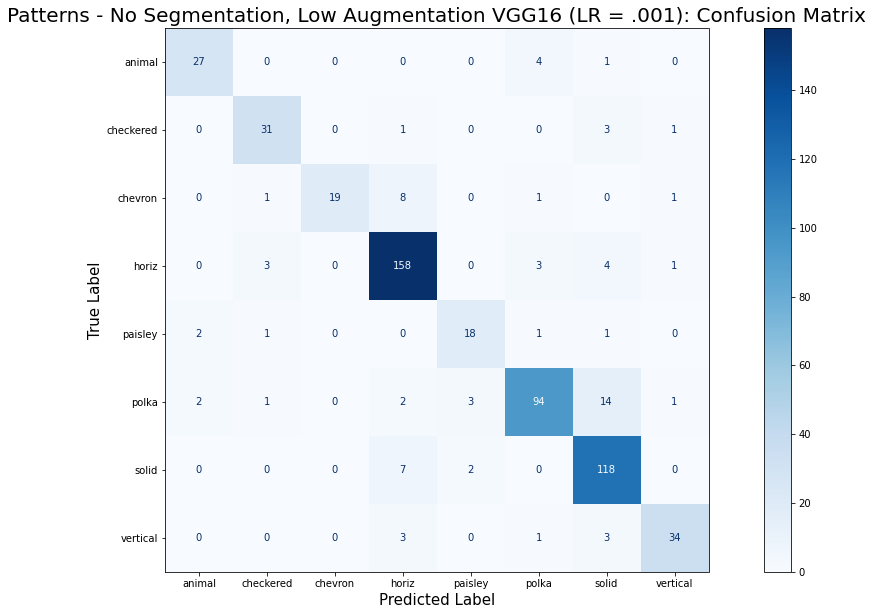

In [ ]:
model_vp_nsa_001 = model_function(tl_model=VGG16,classes = 8,alr=.001)

train_data = tensor_data(train_gen,resampled_df,data_path,
                  'pattern_label','training')

test_data = tensor_data(test_gen,resampled_df,data_path,
                  'pattern_label','validation')

checkpoint_model_vp_nsa_001 = checkpoint('model_vp_nsa_001')

history_vp_nsa_001 = model_vp_nsa_001.fit(
    train_data,
    batch_size = 16,
    epochs=200,
    verbose=0,
    validation_data = test_data,
    callbacks = [checkpoint_model_vp_nsa_001,early_stop],
    validation_batch_size=16
)

plot_accuracy(history_vp_nsa_001,'Patterns - No Segmentation, Low Augmentation VGG16 (LR = .001) : Accuracy',
              'nsa_pattern_vgg16_.001')

plot_confusion_matrix('model_vp_nsa_001',test_data,
                      'Patterns - No Segmentation, Low Augmentation VGG16 (LR = .001): Confusion Matrix',
                      'nsa_pattern_vgg16_.001')

In [ ]:
max(history_vp_nsa_001.history['val_accuracy'])

0.8678261041641235

In [ ]:
calculate_balanced_acc('model_vp_nsa_001',resampled_df,data_path,'pattern_label')

Found 575 non-validated image filenames belonging to 8 classes.


0.8271919171337019

When decreasing the batch size from 32 to 16, and lowering the learning rate from .01 to .001, performance of the VGG16 model in classifying patterns improves: 86.78% validation accuracy versus ~84%, and 82.72% balancwed accuracy versus 80.24%. 

This model will be presented on the Streamlit app that will be built.

## VGG16 Model - No Segmentation, Less Augmentation, LR =.001 - Garment

Found 4218 non-validated image filenames belonging to 9 classes.
Found 1054 non-validated image filenames belonging to 9 classes.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_nsa_001/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_nsa_001/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_nsa_001/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_nsa_001/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_nsa_001/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_nsa_001/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_nsa_001/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/clothing_class/models/model_vg_nsa_001/assets
INFO:tensorflow:Assets written to: /co

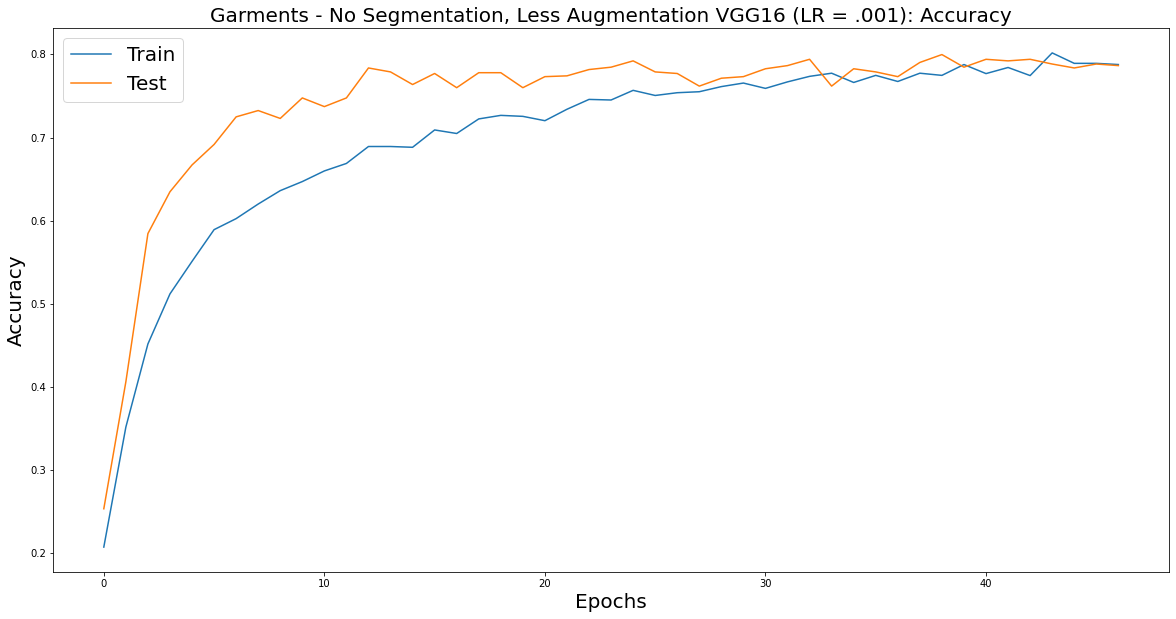

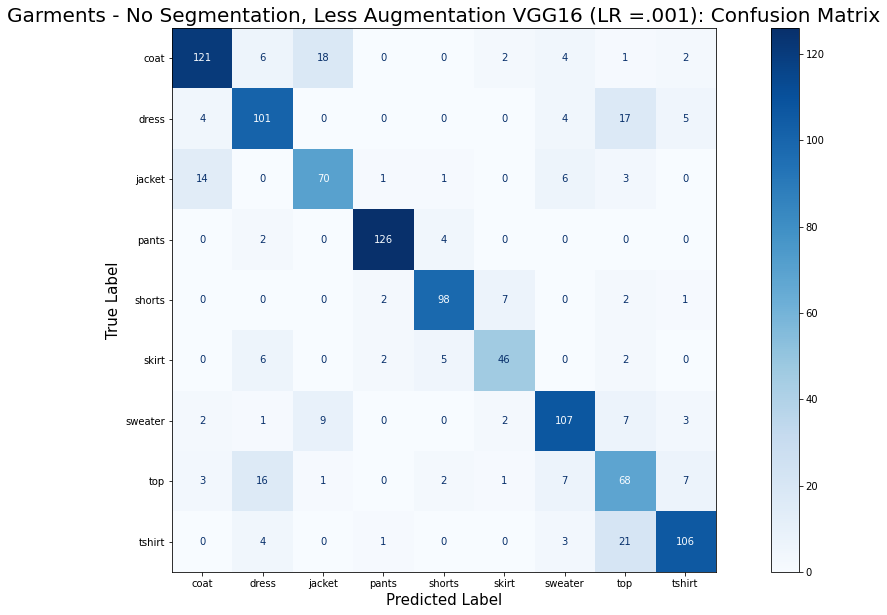

In [ ]:
model_vg_nsa_001 = model_function(tl_model=VGG16,classes = 9,alr=.001)

train_data = tensor_data(train_gen,clothes_df,data_path,
                  'garment_label','training')

test_data = tensor_data(test_gen,clothes_df,data_path,
                  'garment_label','validation')

checkpoint_model_vg_nsa_001 = checkpoint('model_vg_nsa_001')

history_vg_nsa_001 = model_vg_nsa_001.fit(
    train_data,
    batch_size = 16,
    epochs=200,
    verbose=0,
    validation_data = test_data,
    callbacks = [checkpoint_model_vg_nsa_001,early_stop],
    validation_batch_size=16
)

plot_accuracy(history_vg_nsa_001,'Garments - No Segmentation, Less Augmentation VGG16 (LR = .001): Accuracy',
              'nsa_garment_vgg16_001')

plot_confusion_matrix('model_vg_nsa_001',test_data,
                      'Garments - No Segmentation, Less Augmentation VGG16 (LR =.001): Confusion Matrix',
                      'nsa_garment_vgg16_001')

In [ ]:
max(history_vg_nsa_001.history['val_accuracy'])

0.7998102307319641

In [ ]:
calculate_balanced_acc('model_vg_nsa_001',clothes_df,data_path,'garment_label')

Found 1054 non-validated image filenames belonging to 9 classes.


0.7936333099371049

Decreasing batch size and learning rate also improves performance in classifying garments: 79.98% validation accuracy versus the previous model's 73.81%, and 79.36% balanced accuracy versus 71.78% for the previous model.
